In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

In [ ]:
!unzip brain-tumor-mri-dataset.zip

In [1]:
import os
import cv2
import time
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
training_set = '/content/Training'
testing_set = '/content/Testing'

In [3]:
vgg_model = VGG16(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [4]:
for layer in vgg_model.layers:
    layer.trainable = False

In [5]:
flattening_layer = Flatten()(vgg_model.output)

In [6]:
dense_layer_1 = Dense(256,activation='relu')(flattening_layer)
dense_layer_2 = Dense(128,activation='relu')(dense_layer_1)

In [7]:
pred_layer = Dense(4,activation='softmax')(dense_layer_2)

In [8]:
VGG_BTD = Model(inputs=vgg_model.input,outputs=pred_layer)
VGG_BTD.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
VGG_BTD.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
training_image_generator = ImageDataGenerator(rescale = 1./255, horizontal_flip = True)

In [11]:
training_images = training_image_generator.flow_from_directory(training_set,
                                                               batch_size = 32,
                                                               shuffle = True,
                                                               target_size = (224, 224),
                                                               class_mode = 'categorical')

Found 5712 images belonging to 4 classes.


In [12]:
testing_image_generator = ImageDataGenerator(rescale = 1./255)

In [13]:
testing_images = testing_image_generator.flow_from_directory(testing_set,
                                                          batch_size = 32,
                                                          shuffle = True,
                                                          target_size = (224, 224),
                                                          class_mode = 'categorical')

Found 1311 images belonging to 4 classes.


In [14]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}

        val_accuracy = logs.get('val_accuracy')
        if val_accuracy is not None and val_accuracy >= 0.85:
            print(f"\nValidation accuracy reached {val_accuracy * 100:.2f}%. Training is stopped.")
            self.model.stop_training = True

custom_callback = CustomCallback()

In [15]:
start_time = time.time()

VGG_BTD.fit(training_images,
          epochs = 15,
          steps_per_epoch = len(training_images),
          validation_data = testing_images,
          callbacks = [custom_callback])

end_time = time.time()

Epoch 1/15
179/179 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8349
Validation accuracy reached 88.86%. Training is stopped.
179/179 [==============================] - 50s 207ms/step - loss: 0.4790 - accuracy: 0.8349 - val_loss: 0.3167 - val_accuracy: 0.8886


In [16]:
total_time = end_time - start_time
print(f"Total time taken for training: {total_time:.2f} seconds")

Total time taken for training: 50.31 seconds


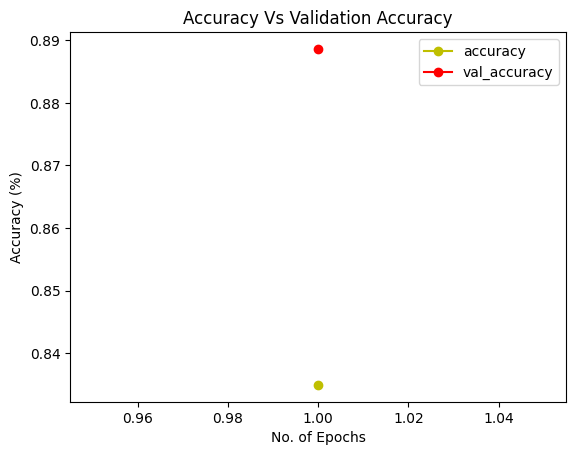

In [20]:
losses = pd.DataFrame(VGG_BTD.history.history)
losses[['accuracy', 'val_accuracy']] *= 100  # Convert to percentage
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'yo-', label='accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='val_accuracy')
plt.title('Accuracy Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy (%)')  # Modify the y-axis label
plt.legend()
plt.show()

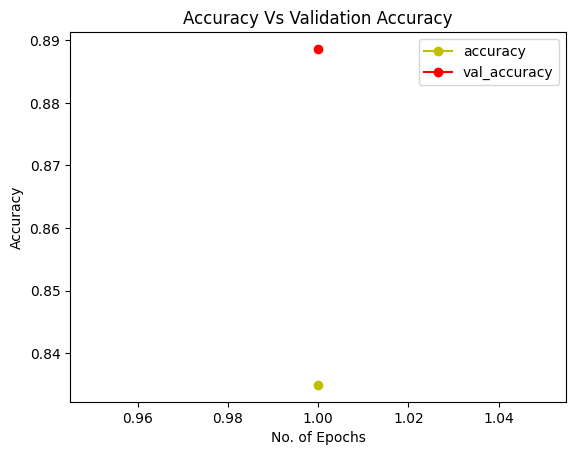

In [19]:
# Assuming you have a variable named 'history' containing the training history
accuracy = VGG_BTD.history.history['accuracy']
val_accuracy = VGG_BTD.history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)

# Plotting the graph with data points
plt.plot(epochs, accuracy, 'yo-', label='accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='val_accuracy')
plt.title('Accuracy Vs Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

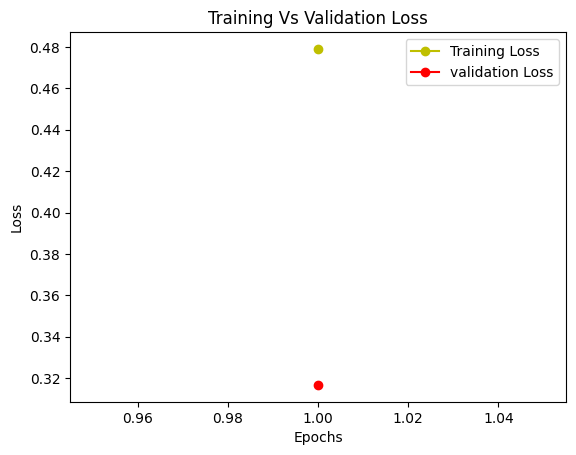

In [21]:
loss = VGG_BTD.history.history['loss']
val_loss = VGG_BTD.history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'yo-', label = 'Training Loss')
plt.plot(epochs, val_loss, 'ro-', label = 'validation Loss')
plt.title('Training Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
predictions = VGG_BTD.predict(testing_images)
print(predictions)

41/41 [==============================] - 5s 123ms/step
[[6.53330162e-02 3.59236926e-01 2.62902264e-04 5.75167179e-01]
 [9.29561675e-01 6.27598837e-02 6.82772486e-04 6.99561555e-03]
 [5.49196272e-07 1.12758709e-04 9.99886632e-01 2.54902695e-08]
 ...
 [1.17676325e-01 6.86496675e-01 1.88370869e-01 7.45614758e-03]
 [4.63710836e-04 8.11133444e-01 1.88388571e-01 1.42346180e-05]
 [3.53211824e-08 1.40631499e-04 9.99858856e-01 4.25318603e-07]]


In [23]:
print(VGG_BTD.evaluate(testing_images))

41/41 [==============================] - 5s 126ms/step - loss: 0.3167 - accuracy: 0.8886
[0.3166930675506592, 0.8886346220970154]


Found 1311 images belonging to 4 classes.
Total number of samples: 1311


Number of batches: 40
40/40 [==============================] - 5s 124ms/step
40 Batches are processed


Number of batches: 41
41/41 [==============================] - 5s 130ms/step
41 Batches are processed (Same Batches)


Number of batches: 41
41/41 [==============================] - 5s 126ms/step
41 Batches are processed (Same Batches)


True Labels: 1311
Predicted Labels: 1311


First Matrix is Normalized Confusion Matrix

Second Confusion Matrix is Without Normalization


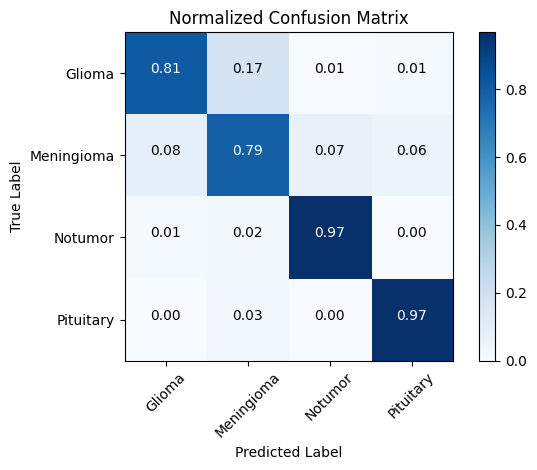

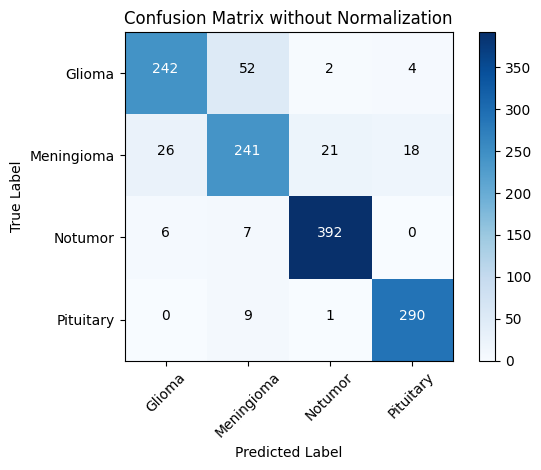

In [24]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    testing_set,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle = False
)

true_labels = test_generator.classes
num_samples = len(true_labels)

num_batches = num_samples // test_generator.batch_size
print("Total number of samples:", num_samples)
print("\n")

print("Number of batches:", num_batches)
predictions = VGG_BTD.predict(test_generator, steps = num_batches, verbose = 1)
# When verbose = 1, it will show a progress bar during the prediction
print("40 Batches are processed")
print("\n")
print("Number of batches:", num_batches + 1)
predictions = VGG_BTD.predict(test_generator, steps = num_batches + 1, verbose = 1)
print("41 Batches are processed (Same Batches)")
print("\n")
print("Number of batches:", num_batches + 1)
predictions = VGG_BTD.predict(test_generator, steps = num_samples // test_generator.batch_size + 1, verbose = 1)
predicted_labels = np.argmax(predictions, axis = 1)
print("41 Batches are processed (Same Batches)")
print("\n")

actual_label = len(true_labels)
pred_label = len(predicted_labels)
print(f"True Labels: {actual_label}\nPredicted Labels: {pred_label}")
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ["Glioma", "Meningioma", "Notumor", "Pituitary"]

def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("\n")
        print("First Matrix is Normalized Confusion Matrix\n")
    else:
        print('Second Confusion Matrix is Without Normalization')

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = True, title = 'Normalized Confusion Matrix')

plt.figure()
plot_confusion_matrix(cm, classes = class_names, normalize = False, title = 'Confusion Matrix without Normalization')

plt.show()